<a href="https://colab.research.google.com/github/arekangel/AI_AUTH_2025_Areklakis_Aggelos/blob/main/final_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

import matplotlib.pyplot as plt


TRAIN_FEAT_PATH = "/content/train_hh_features.csv"
TRAIN_GT_PATH   = "/content/train_hh_gt.csv"

X_df = pd.read_csv(TRAIN_FEAT_PATH)
y_df = pd.read_csv(TRAIN_GT_PATH)

df = X_df.merge(y_df, on=["survey_id", "hhid"], how="inner")

print("Merged shape:", df.shape)
df.head()


Merged shape: (104234, 89)


,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


sector1d         0.135551
dweltyp          0.011570
utl_exp_ppp17    0.000815
consumed5000     0.000633
consumed4900     0.000537
consumed4800     0.000537
consumed4600     0.000537
consumed4500     0.000518
consumed4400     0.000499
consumed4300     0.000499
consumed4700     0.000499
employed         0.000432
consumed4200     0.000422
consumed4100     0.000384
consumed3900     0.000384
dtype: float64
count    104234.000000
mean         11.555229
std          10.034225
min           0.359563
25%           5.439294
50%           8.774002
75%          14.216931
max         236.115680
Name: cons_ppp17, dtype: float64
Categorical: 64
Numeric: 24


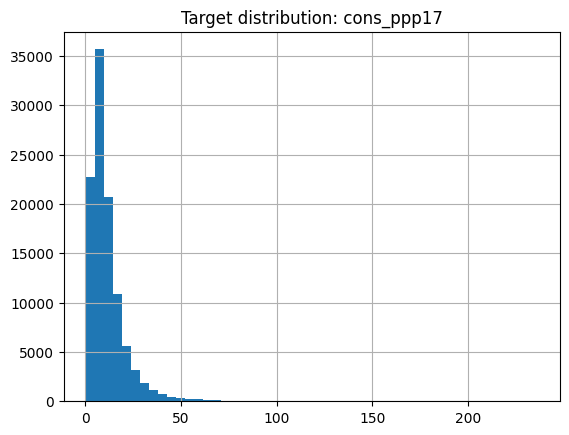

In [ ]:
missing = df.isna().mean().sort_values(ascending=False).head(15)
print(missing)


print(df["cons_ppp17"].describe())


cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in df.columns if c not in cat_cols and c not in ["cons_ppp17"]]

print("Categorical:", len(cat_cols))
print("Numeric:", len(num_cols))


plt.figure()
df["cons_ppp17"].hist(bins=50)
plt.title("Target distribution: cons_ppp17")
plt.show()

In [ ]:
X = df.drop(columns=["cons_ppp17"])
y = df["cons_ppp17"].values

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, [c for c in X.columns if X[c].dtype != "object"]),
        ("cat", categorical_transformer, [c for c in X.columns if X[c].dtype == "object"])
    ],
    remainder="drop"
)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "HistGB": HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
    mae_scores = -scores
    results.append({
        "model": name,
        "MAE_mean": mae_scores.mean(),
        "MAE_std": mae_scores.std()
    })

results_df = pd.DataFrame(results).sort_values("MAE_mean")
results_df

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,model,MAE_mean,MAE_std
2,HistGB,3.429465,0.021893
1,RandomForest,3.503870,0.011626
0,Ridge,4.115048,0.011181


In [ ]:
candidates = [
    HistGradientBoostingRegressor(learning_rate=0.05, max_depth=4, random_state=42),
    HistGradientBoostingRegressor(learning_rate=0.05, max_depth=6, random_state=42),
    HistGradientBoostingRegressor(learning_rate=0.03, max_depth=6, random_state=42),
]

tune_rows = []
for i, m in enumerate(candidates):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", m)])
    scores = cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
    tune_rows.append({
        "candidate": i,
        "learning_rate": m.learning_rate,
        "max_depth": m.max_depth,
        "MAE_mean": (-scores).mean()
    })

pd.DataFrame(tune_rows).sort_values("MAE_mean")

,candidate,learning_rate,max_depth,MAE_mean
1,1,0.05,6,3.429465
0,0,0.05,4,3.522146
2,2,0.03,6,3.573727


In [ ]:
!pip -q install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split

categorical_transformer_dense = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, [c for c in X.columns if X[c].dtype != "object"]),
        ("cat", categorical_transformer_dense, [c for c in X.columns if X[c].dtype == "object"])
    ],
    remainder="drop"
)

X_dense = preprocess_dense.fit_transform(X)
X_dense = X_dense.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X_dense, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mae",
    metrics=["mae"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


pred_val = model.predict(X_val).ravel()
print("MLP Validation MAE:", mean_absolute_error(y_val, pred_val))


plt.figure()
plt.plot(hist.history["loss"], label="train_mae")
plt.plot(hist.history["val_loss"], label="val_mae")
plt.title("MLP MAE history")
plt.legend()
plt.show()

In [ ]:

best_model = HistGradientBoostingRegressor(learning_rate=0.05, max_depth=6, random_state=42)
best_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", best_model)])

best_pipe.fit(X, y)

def make_submission(best_pipe, test_csv_path, out_path="submission.csv"):
    test_df = pd.read_csv(test_csv_path)
    preds = best_pipe.predict(test_df)
    sub = test_df[["survey_id", "hhid"]].copy()
    sub["cons_ppp17"] = preds
    sub.to_csv(out_path, index=False)
    return sub

